# Load libraries and data

In [245]:
library(phyloseq); packageVersion("phyloseq")
library(dada2)
library(ggplot2); packageVersion("ggplot2")
library(tidyr)
library(dplyr)
library(tibble)
library(vegan); packageVersion("vegan")
library(scales)
library(repr)
library(reshape2)
library(genefilter)
library(microbiome)
library(VennDiagram)
library(svglite)
library(viridis)
library(RColorBrewer)

#library(gridExtra)
library(DESeq2); packageVersion("DESeq2")

options(jupyter.plot_mimetypes = c("text/plain", "image/png" ))

#colorblind color vector for taxonomy plots
colors <- c("#89C5DA", "#DA5724", "#74D944", "#CE50CA", "#3F4921", "#C0717C", "#CBD588", "#5F7FC7", 
            "#673770", "#D3D93E", "#38333E", "#508578", "#D7C1B1", "#689030", "#AD6F3B", "#CD9BCD", 
            "#D14285", "#6DDE88", "#652926", "#7FDCC0", "#C84248", "#8569D5", "#5E738F", "#D1A33D", 
            "#8A7C64", "#599861", "orange", "666666", "gray80", "#FFCC00")

set.seed(100)

[1] ‘1.44.0’

[1] ‘3.4.2’

[1] ‘2.6.4’

[1] ‘1.40.1’

In [246]:
ps <- readRDS("~/data/awtp2/amplicon_16S/ps_clean_filt.rds")

In [247]:
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6825 taxa and 156 samples ]
sample_data() Sample Data:       [ 156 samples by 23 sample variables ]
tax_table()   Taxonomy Table:    [ 6825 taxa by 7 taxonomic ranks ]

In [248]:
#change ASV names to short codes, store DNA seqs in ref_seq object in phyloseq
dna <- Biostrings::DNAStringSet(taxa_names(ps))
names(dna) <- taxa_names(ps)
ps <- merge_phyloseq(ps, dna)
taxa_names(ps) <- paste0("ASV", seq(ntaxa(ps)))
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 6825 taxa and 156 samples ]
sample_data() Sample Data:       [ 156 samples by 23 sample variables ]
tax_table()   Taxonomy Table:    [ 6825 taxa by 7 taxonomic ranks ]
refseq()      DNAStringSet:      [ 6825 reference sequences ]

In [249]:
# select only samples of interest
ps_awtp <- subset_samples(ps, subset = project_type %in% c("DPWF"))
ps_awtp <- filter_taxa(ps_awtp, function(x) sum(x) > 0, TRUE) #keep only seqs that had reads after filtering   

In [250]:
# change location_code names to RO_BF_feed and RO_BF_perm
# first change from factor to character, then replace names, then change back again with desired order

sample_data(ps_awtp)$location_code <- as.character(sample_data(ps_awtp)$location_code)
sample_data(ps_awtp)[sample_data(ps_awtp)=="RO_BF_retentate_scrapings"]<- "RO_BF_feed"
sample_data(ps_awtp)[sample_data(ps_awtp)=="RO_BF_separator"]<- "RO_BF_perm"

In [251]:
unique(sample_data(ps_awtp)$location_code)

[1] "RO_BF_perm"  "MF_combined" "BAC"         "RO_BF_feed"  "WW_3ary"    
[6] "RO_combined" "RO_3stage"   "RO_2stage"

In [252]:
# Add new column with general location information to metadata
sample_data(ps_awtp)$location_gen <- sample_data(ps_awtp)$location_code

# Order levels according to treatment train
new_levels <- c('WW_3ary',
'BAC',
'MF_combined',
'MF_tank',
'MF',
'RO_BF_feed', #used to be retentate scrapings
'RO_BF_perm', #used to be separator
'RO_combined',
'RO_3stage',
'RO_2stage',
'RO')

sample_data(ps_awtp)$location_gen <- factor(sample_data(ps_awtp)$location_gen, levels=new_levels)
sample_data(ps_awtp)$location_code <- factor(sample_data(ps_awtp)$location_code, levels=new_levels)

In [253]:
# Change factor levels to condense down to simple location
sample_data(ps_awtp)[sample_data(ps_awtp)$location_code %in% c("MF_tank", "MF_combined"),]$location_gen <- "MF"
sample_data(ps_awtp)[sample_data(ps_awtp)$location_code %in% c("RO", 
                                        "RO_combined", "RO_3stage", "RO_2stage"),]$location_gen <- "RO"

In [254]:
# reset levels to collapsed levels
levels(sample_data(ps_awtp)$location_gen) <- list("Tertiary_WW" = "WW_3ary", 
                                                  "BAC" = "BAC",
                                                  "MF" = "MF",
                                                  "Feed" ="RO_BF_feed",
                                                  "Perm" = "RO_BF_perm",
                                                  "RO" = "RO")
                                                  
sample_data(ps_awtp)$location_gen
sample_data(ps_awtp)$location_code

[1] Perm        MF          BAC         Feed        BAC         Tertiary_WW
 [7] Tertiary_WW Feed        Tertiary_WW Tertiary_WW BAC         RO         
[13] RO          RO          RO          RO          MF          MF         
[19] BAC         BAC         RO          RO          RO          Perm       
[25] RO          RO          RO         
Levels: Tertiary_WW BAC MF Feed Perm RO

[1] RO_BF_perm  MF_combined BAC         RO_BF_feed  BAC         WW_3ary    
 [7] WW_3ary     RO_BF_feed  WW_3ary     WW_3ary     BAC         RO_combined
[13] RO_3stage   RO_2stage   RO_3stage   RO_2stage   MF_combined MF_combined
[19] BAC         BAC         RO_3stage   RO_3stage   RO_3stage   RO_BF_perm 
[25] RO_2stage   RO_2stage   RO_2stage  
11 Levels: WW_3ary BAC MF_combined MF_tank MF RO_BF_feed ... RO

In [255]:
# construct new names from other columns, make sure they can match to metagenomic names

sample_data(ps_awtp)$sample_date <- as.Date(sample_data(ps_awtp)$sample_date, format = "%m/%d/%Y")
day0 <- as.Date("2017-9-14") # This is the first day of sampling
sample_data(ps_awtp)$sample_day <- as.numeric(sample_data(ps_awtp)$sample_date - day0)
sample_data(ps_awtp)$sample_name <- stringr::str_c(sample_data(ps_awtp)$location_code, "_", sample_data(ps_awtp)$sample_day)

In [256]:
# sort sample_name and make factor so they will plot in order
name_levels <- sample_data(ps_awtp)[order(sample_data(ps_awtp)$location_code, sample_data(ps_awtp)$sample_date)]$sample_name
sample_data(ps_awtp)$sample_name <- factor(sample_data(ps_awtp)$sample_name, levels=name_levels)

In [213]:
# count number of unique ASVs per sample and save for plotting elsewhere
asv_count <- as.data.frame(otu_table(ps_awtp))
asv_count <- asv_count > 0
asv_count <- rowSums(asv_count)
asv_count <- as.data.frame(asv_count)
#write.table(asv_count, '~/data/awtp2/amplicon_16S/asv_count.tsv', sep='\t', quote=FALSE)

# Analyses with contam

In [257]:
ps_dpwf_perc <- transform_sample_counts(ps_awtp, function(x) 100*x/sum(x))
ps_dpwf_perc_filt1.3 <- filter_taxa(ps_dpwf_perc, filterfun(kOverA(1, 3)), TRUE)

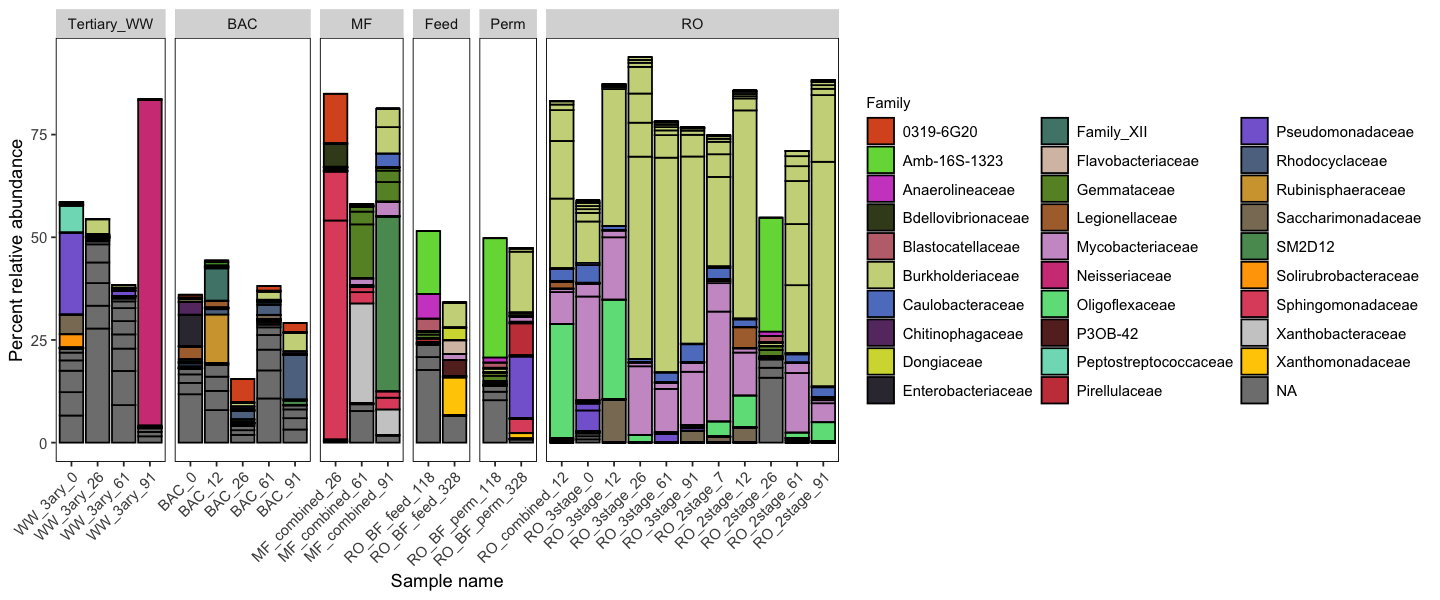

In [258]:
# Family barplot
options(repr.plot.width = 12, repr.plot.height = 5)

colors2 = colors[-1] 

plot_bar(ps_dpwf_perc_filt1.3, x="sample_name", fill="Family") + scale_fill_manual(values = colors2) + 
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9),
        axis.text.y = element_text(size=9),
        legend.text=element_text(size=9), 
        legend.title=element_text(size=9))+
    facet_grid(.~location_gen, scale="free_x", space="free_x")+
ylab("Percent relative abundance") +
xlab("Sample name")+
guides(fill=guide_legend(ncol=3))
# ggsave("~/data/awtp2/amplicon_16S/figures/barplot_dpwf_bulk_perc_filt1.3_family_contam.png", device="png", width=12, height=5)
# ggsave("~/data/awtp2/amplicon_16S/figures/barplot_dpwf_bulk_perc_filt1.3_family_contam.svg", device="svg", width=12, height=5)

Square root transformation
Wisconsin double standardization
Run 0 stress 0.1073102 
Run 1 stress 0.1104849 
Run 2 stress 0.1073102 
... New best solution
... Procrustes: rmse 4.599541e-06  max resid 1.140071e-05 
... Similar to previous best
Run 3 stress 0.1104849 
Run 4 stress 0.1085035 
Run 5 stress 0.1104849 
Run 6 stress 0.1104849 
Run 7 stress 0.1073102 
... Procrustes: rmse 1.647693e-05  max resid 5.687285e-05 
... Similar to previous best
Run 8 stress 0.1104849 
Run 9 stress 0.1104849 
Run 10 stress 0.1085035 
Run 11 stress 0.1073102 
... New best solution
... Procrustes: rmse 3.164164e-06  max resid 8.531416e-06 
... Similar to previous best
Run 12 stress 0.1104849 
Run 13 stress 0.1073102 
... Procrustes: rmse 2.318545e-06  max resid 6.994679e-06 
... Similar to previous best
Run 14 stress 0.1073102 
... Procrustes: rmse 2.458278e-06  max resid 6.384274e-06 
... Similar to previous best
Run 15 stress 0.1104851 
Run 16 stress 0.1073102 
... New best solution
... Procrustes: rms

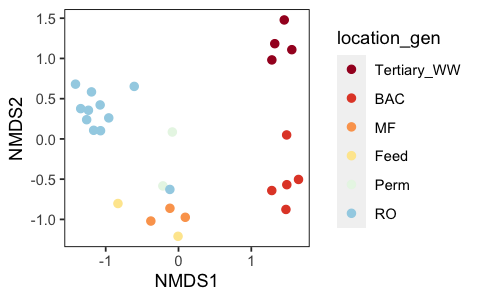

In [259]:
# Plot 
ps_dpwf_perc.ord <- ordinate(ps_dpwf_perc, "NMDS", "bray")
options(repr.plot.width = 4, repr.plot.height = 2.5)

plot_ordination(ps_dpwf_perc, ps_dpwf_perc.ord, color="location_gen") + 
    geom_point(size=2)+
    scale_color_manual(values=colorRampPalette(brewer.pal(11, "RdYlBu"))(8))+
    #geom_text(aes(label=SampleID),hjust=1, vjust=1)+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))
#ggsave('~/data/awtp2/amplicon_16S/figures/dpwf_NMDS_contam.png', device='png', width = 4, height = 2.5)
ggsave('~/data/awtp2/amplicon_16S/figures/dpwf_NMDS_contam.svg', device='svg', width = 4, height = 2.5)

# Normalize data and add combined taxonomy label

In [301]:
# Remove contaminated sample AWTP_2_RO2_bulk_4_B_Test_June2_W12 from dataset 
ps_awtp <- subset_samples(ps_awtp, subset = !(sample_code_full_and_batch %in% "AWTP_2_RO2_bulk_4_B_Test_June2_W12"))

# note: within the decontam notebook, we created a "combined" taxa label:
# ranks <- c("Phylum", "Family", "Genus")
# combined_labels <- apply(tax_table(ps_raw)[ , ranks] , 1 , paste , sep = "", collapse = ">" )
# tax_table(ps_raw) <- cbind(tax_table(ps_raw), combined=combined_labels)

ranks <- c("Phylum", "Family")
combined_labels <- apply(tax_table(ps_awtp)[ , ranks] , 1 , paste , sep = "", collapse = ">" )
tax_table(ps_awtp) <- cbind(tax_table(ps_awtp), phyfam=combined_labels)

# subset and normalize to percents
ps_dpwf_perc <- transform_sample_counts(ps_awtp, function(x) 100*x/sum(x))
ps_dpwf_bulk <- subset_samples(ps_awtp, subset = !(location_gen %in% c('Feed', 'Perm')))
ps_dpwf_bulk_perc <- transform_sample_counts(ps_dpwf_bulk, function(x) 100*x/sum(x))

# Alpha diversity

In [226]:
otu_tab <- as.data.frame(otu_table(ps_awtp))

locations_colors <- c(colors[1],colors[2],colors[3],colors[4],colors[5],colors[10], colors[11], colors[12])
palette(c(colors[1],colors[2],colors[3],colors[4],colors[5],colors[10], colors[11], colors[12]))
#locations_colors <- colorRampPalette(brewer.pal(11, "RdYlBu"))(8)
#palette(location_colors)

options(repr.plot.width = 8, repr.plot.height = 5)

#pdf("~/data/awtp2/amplicon_16S/figures/rarecurve_dpwf_nolabels.pdf", height=5, width=8)
rarecurve(otu_tab,
          step=100,
          col=sample_data(ps_awtp)$location_gen, 
          xlab="Reads",
          ylab="Amplicon Sequence Variants (ASVs)",
          lwd=2,
          ylim=c(0,1500),
          label=FALSE)

legend("topleft", 
       legend=c('Tertiary_WW','BAC','MF','RO_BF_feed','RO_BF_perm','RO'), 
       col=locations_colors, 
       lty=1, lwd=2)
#dev.off()

Warning message in rarecurve(otu_tab, step = 100, col = sample_data(ps_awtp)$location_gen, :
“most observed count data have counts 1, but smallest count is 2”


pdf 
  2

Warning message in estimate_richness(physeq, split = TRUE, measures = measures):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


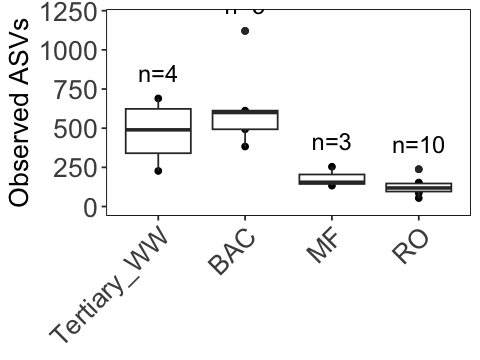

In [227]:
n_fun <- function(x){return(data.frame(y = max(x), label = paste0("n=",length(x))))}
options(repr.plot.width = 4, repr.plot.height = 3)

plot_richness(ps_dpwf_bulk, x="location_gen", measures=c("Observed"))+
    geom_boxplot()+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
     strip.background = element_blank(), 
     strip.text.x = element_blank(),
     axis.title.x = element_blank(),
     axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=16),
     axis.text.y = element_text(size=16),
     axis.title.y=element_text(size=16))+
    ylab("Observed ASVs") +
    ylim(0, 1200)+
    #scale_y_continuous(trans="log10", limits=c(1,1800), labels=trans_format("log10", math_format(10^.x)))+
    stat_summary(fun.data = n_fun, geom = "text", vjust=-1, size=5)+
    facet_grid(.~project_type, scale="free_x", space="free_x")

# ggsave("~/data/awtp2/amplicon_16S/figures/asv_observed_boxplot_dpwf_bulk.png", device="png", width=5, height=3)
# ggsave("~/data/awtp2/amplicon_16S/figures/asv_observed_boxplot_dpwf_bulk.pdf", device="pdf", width=8, height=3)

# Richness is a function of how much volume/how many cells we sampled... need to normalize for that somehow, including recovery efficiency

Warning message in estimate_richness(physeq, split = TRUE, measures = measures):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”


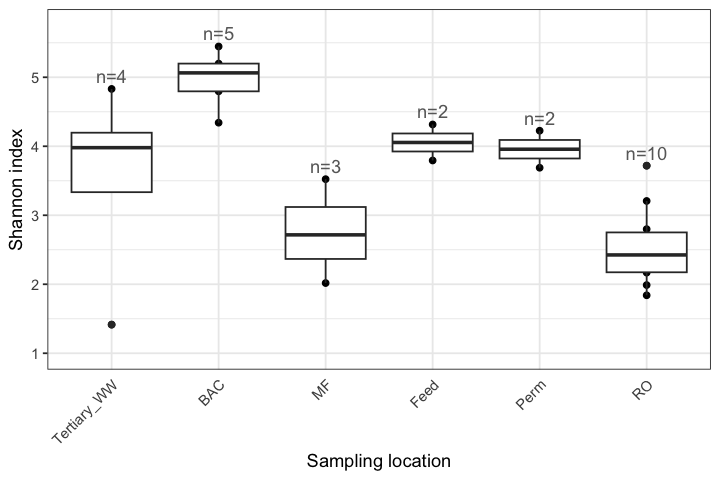

In [228]:
n_fun <- function(x){return(data.frame(y = max(x), label = paste0("n=",length(x))))}

options(repr.plot.width = 6, repr.plot.height = 4)
#locations_colors <- colorRampPalette(brewer.pal(11, "RdYlBu"))(8)
#palette(location_colors)
plot_adiv_sh <- plot_richness(ps_awtp, x="location_gen", measures=c("Shannon"))+
    geom_boxplot()+ #aes(fill=location_gen)
    ylab("Shannon index") +
    xlab("Sampling location")+
    ylim(1, 5.75)+
#     scale_fill_manual(values = colorRampPalette(brewer.pal(11, "RdYlBu"))(8),
#                       name="Location",labels=c("Tertiary wastewater","BAC","MF","RO biofilm feed",
#                                                                "RO biofilm permeate","RO"))+
    stat_summary(fun.data = n_fun, geom = "text", vjust=-0.5,colour = "#696969")+
    theme_bw()+
    theme(axis.text.x=element_text(angle=45, hjust=1),
    axis.ticks.x=element_blank(),
    strip.text.x = element_blank())
plot_adiv_sh

ggsave("~/data/awtp2/amplicon_16S/figures/alpha_div_shannon_dpwf_bulk_bw.png", device="png", height=3, width=5)

In [264]:
sample_data(ps_awtp) <- sample_data(ps_awtp) %>% add_column(shannon = NA)
sample_data(ps_awtp)$shannon <- estimate_richness(ps_awtp,  split= TRUE, measure= "Shannon")

pairwise.wilcox.test(as.matrix(sample_data(ps_awtp)$shannon), as.matrix(sample_data(ps_awtp)$location_gen),
                 p.adjust.method = "hochberg")

Warning message in estimate_richness(ps_awtp, split = TRUE, measure = "Shannon"):
“The data you have provided does not have
any singletons. This is highly suspicious. Results of richness
estimates (for example) are probably unreliable, or wrong, if you have already
trimmed low-abundance taxa from the data.

We recommended that you find the un-trimmed data and retry.”



	Pairwise comparisons using Wilcoxon rank sum exact test 

data:  as.matrix(sample_data(ps_awtp)$shannon) and as.matrix(sample_data(ps_awtp)$location_gen) 

            BAC  Feed MF   Perm RO  
Feed        0.86 -    -    -    -   
MF          0.46 1.00 -    -    -   
Perm        0.86 1.00 1.00 -    -   
RO          0.01 0.42 1.00 0.70 -   
Tertiary_WW 0.70 1.00 1.00 1.00 1.00

P value adjustment method: hochberg 

In [269]:
# export as csv to plot with FCM data
sample_data_shannon <- as.data.frame(as.matrix(sample_data(ps_awtp)))
sample_data_shannon <- sample_data_shannon %>% select('location_code', 'sample_day', 'shannon')
write.table(sample_data_shannon, '~/data/awtp2/amplicon_16S/asv_shannon.tsv', sep='\t', quote=FALSE)

# Taxonomic composition

In [230]:
ps_dpwf_perc_filt1.3 <- filter_taxa(ps_dpwf_perc, filterfun(kOverA(1, 3)), TRUE)
ps_dpwf_perc_filt1.3
ps_dpwf_perc_filt2.1 <- filter_taxa(ps_dpwf_perc, filterfun(kOverA(2, 1)), TRUE)
ps_dpwf_perc_filt2.1
ps_dpwf_perc_filt1.1 <- filter_taxa(ps_dpwf_perc, filterfun(kOverA(1, 1)), TRUE)
ps_dpwf_perc_filt1.1

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 75 taxa and 26 samples ]
sample_data() Sample Data:       [ 26 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 75 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 75 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 71 taxa and 26 samples ]
sample_data() Sample Data:       [ 26 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 71 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 71 reference sequences ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 200 taxa and 26 samples ]
sample_data() Sample Data:       [ 26 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 200 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 200 reference sequences ]

## Barplots

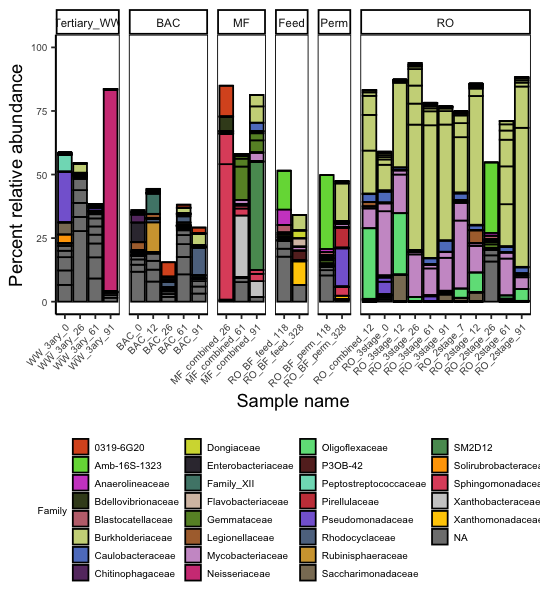

In [292]:
# Family
options(repr.plot.width = 4.5, repr.plot.height = 5)

colors2 = colors[-1] 

plot_bar(ps_dpwf_perc_filt1.3, x="sample_name", fill="Family") + scale_fill_manual(values = colors2) + 
    ylim(0,100)+
    theme_classic()+
    theme(panel.background=element_blank(), 
          panel.border=element_rect(color = "black", fill = NA),
          axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=6),
          axis.text.y = element_text(size=6),
          strip.text = element_text(size=7),
          legend.text=element_text(size=6), 
          legend.title=element_text(size=6),
          legend.key.size = unit(0.15, 'in'),
          legend.position="bottom")+
    facet_grid(.~location_gen, scale="free_x", space="free_x")+
ylab("Percent relative abundance") +
xlab("Sample name")+
guides(fill=guide_legend(ncol=4))
# ggsave("~/data/awtp2/amplicon_16S/figures/barplot_dpwf_bulk_perc_filt1.3_family.png", device="png", width=12, height=5)
# ggsave("~/data/awtp2/amplicon_16S/figures/barplot_dpwf_bulk_perc_filt1.3_family.pdf", device="pdf", width=12, height=5)
ggsave("~/data/awtp2/amplicon_16S/figures/barplot_dpwf_bulk_perc_filt1.3_family.svg", device="svg", width=4.5, height=5)

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 16 taxa and 26 samples ]
sample_data() Sample Data:       [ 26 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 16 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 16 reference sequences ]

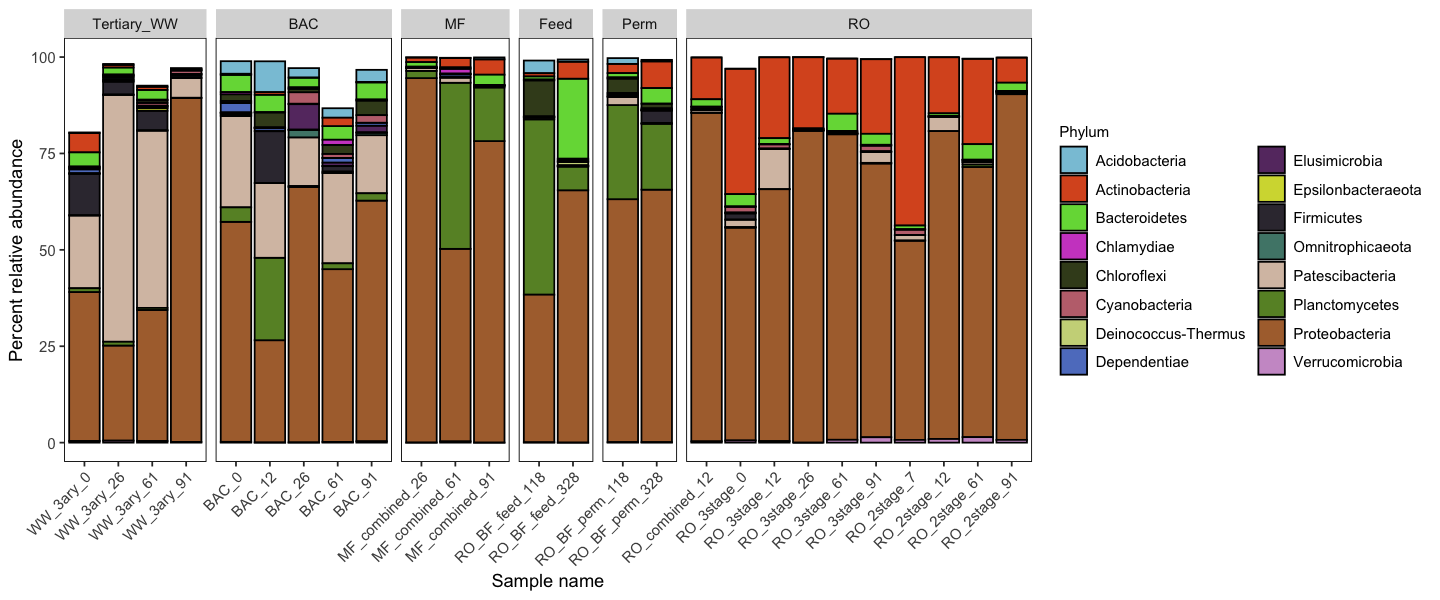

In [232]:
## Phyla agglomerated barplot

ps_dpwf_perc_phylum <- tax_glom(ps_dpwf_perc, "Phylum")
ps_dpwf_perc_phylum_filt1.05 <- filter_taxa(ps_dpwf_perc_phylum, filterfun(kOverA(1, 0.5)), TRUE)
ps_dpwf_perc_phylum_filt1.05

## Plot bar and heatmap
options(repr.plot.width = 12, repr.plot.height = 5)

plot_bar(ps_dpwf_perc_phylum_filt1.05, x="sample_name", fill="Phylum") + scale_fill_manual(values = colors) + 
  theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
        axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9),
        axis.text.y = element_text(size=9),
        legend.text=element_text(size=9), 
        legend.title=element_text(size=9))+
    facet_grid(.~location_gen, scale="free_x", space="free_x")+
ylab("Percent relative abundance") +
xlab("Sample name")+
guides(fill=guide_legend(ncol=2))
# ggsave("~/data/awtp2/amplicon_16S/figures/barplot_dpwf_perc_filt1_over0.5_phylum.png", device="png", width=12, height=5)

## Heatmaps

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Transformation introduced infinite values in discrete y-axis”
Warning message:
“Transformation introduced infinite values in discrete y-axis”
Warning message:
“Transformation introduced infinite values in discrete y-axis”
Warning message:
“Transformation introduced infinite values in discrete y-axis”


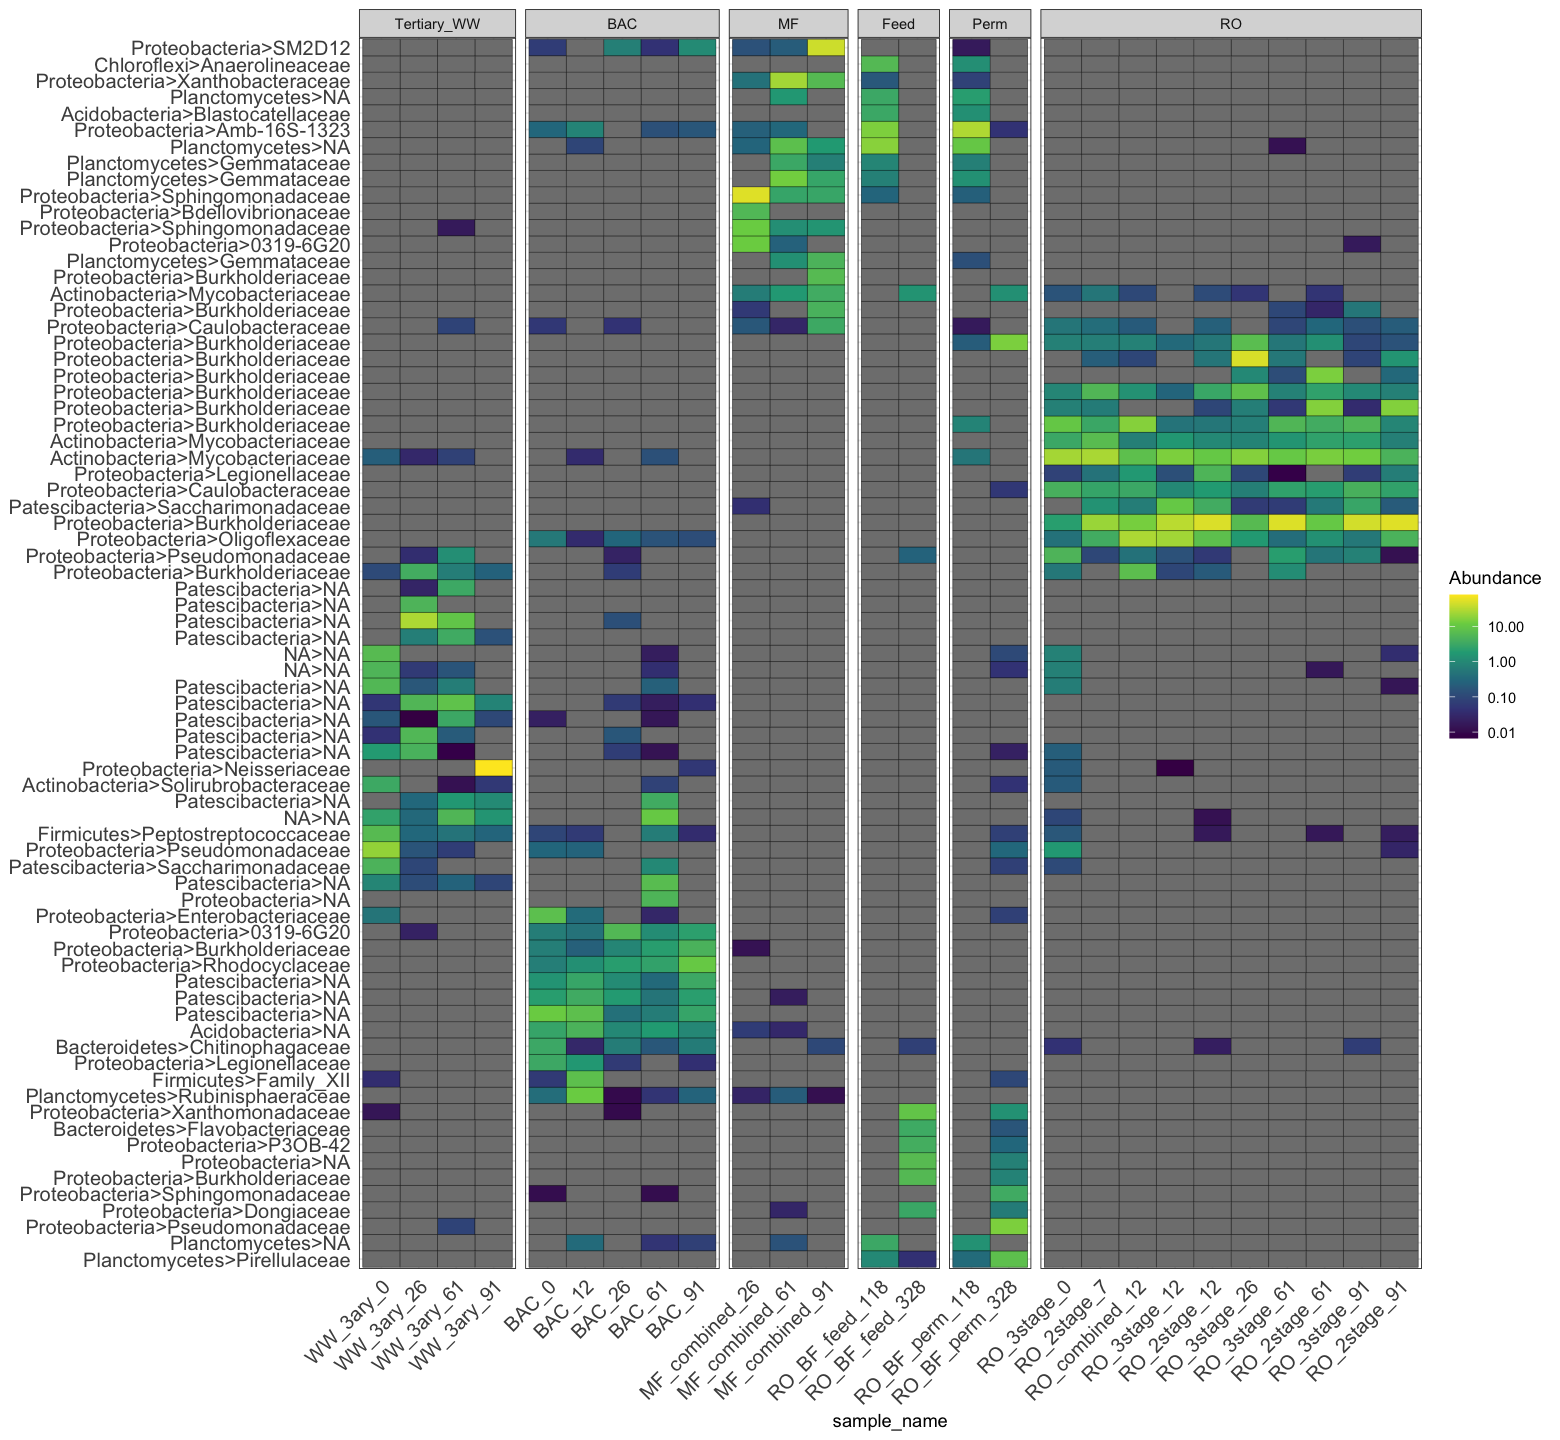

In [238]:
#plot heatmap: all taxa in at least 1 sample at >3% relative abund (ps_dpwf_perc_filt1.3)
options(repr.plot.width = 13, repr.plot.height = 12)
plot_heatmap(ps_dpwf_perc_filt1.3, taxa.label = "phyfam", sample.label = "sample_name", sample.order = "sample_date", method="NMDS")+
    scale_fill_continuous(type='viridis', trans = log_trans(10))+
    facet_grid(.~location_gen, scale="free_x", space="free_x")+
    geom_tile(color="black")+
    theme_bw()+
    theme(axis.text.y = element_text(size=12), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12))
#ggsave("~/data/awtp2/amplicon_16S/figures/heatmap_dpwf_perc_filt1.3.png", device="png", width=12, height=12)

## Examining RO membrane samples (and MF and RO perm)

In [234]:
# # plotting just single locations to see more depth
# ps_ROmem <- subset_samples(ps_dpwf_perc, subset = location_gen %in% c("MF", "RO", "Feed","Perm"))
# ps_ROmem_filt <- filter_taxa(ps_ROmem, filterfun(kOverA(1, 2.5)), TRUE)
# ps_ROmem_filt

# #plot heatmap
# options(repr.plot.width = 12, repr.plot.height = 10)
# plot_heatmap(ps_ROmem_filt, taxa.label = "phyfam", sample.label = "sample_name", sample.order = "sample_date", method="NMDS")+
#             scale_fill_continuous(type='viridis', trans = log_trans(10))+
#      theme(axis.text.y = element_text(size=12), 
#            axis.title.y = element_blank(), 
#            axis.ticks = element_blank(),
#            axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12))+
#      facet_grid(.~location_gen, scale="free_x", space="free_x")
# #ggsave("~/data/awtp2/amplicon_16S/figures/heatmap_MFRO.png", device="png", width=8, height=8)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Transformation introduced infinite values in discrete y-axis”
Warning message:
“Transformation introduced infinite values in discrete y-axis”
Warning message:
“Transformation introduced infinite values in discrete y-axis”
Warning message:
“Transformation introduced infinite values in discrete y-axis”


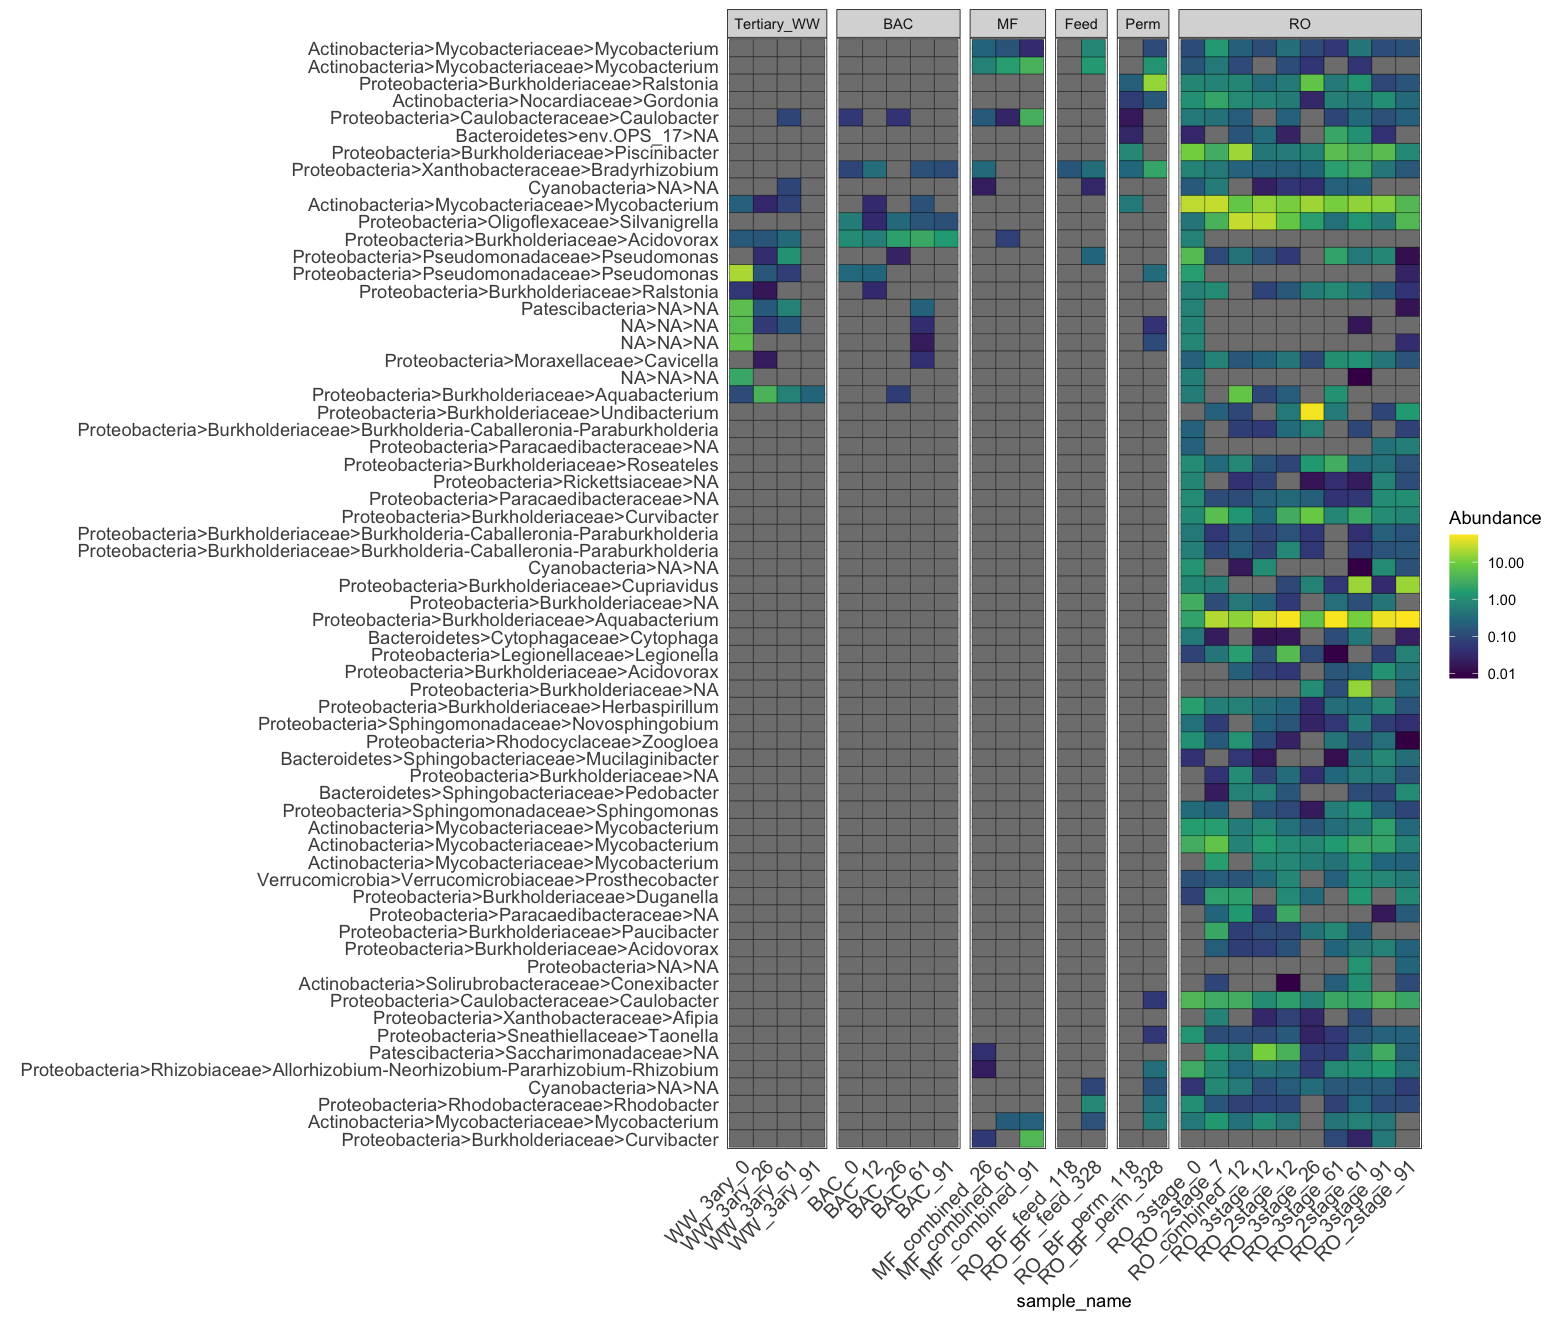

In [244]:
# plotting just single locations to see more depth
ps_ROmem <- subset_samples(ps_dpwf_perc, subset = location_gen %in% c("RO"))
ps_ROmem_tax <- filter_taxa(ps_ROmem, filterfun(kOverA(1, 0.5)), prune=FALSE)
ps_ROmem_filt <- prune_taxa(ps_ROmem_tax, ps_dpwf_perc)

#plot heatmap
options(repr.plot.width = 13, repr.plot.height = 11)
plot_heatmap(ps_ROmem_filt, taxa.label = "combined", sample.label = "sample_name", sample.order = "sample_date", method="NMDS")+
    scale_fill_continuous(type='viridis', trans = log_trans(10))+
    facet_grid(.~location_gen, scale="free_x", space="free_x")+
    geom_tile(color="black")+
    theme_bw()+
    theme(axis.text.y = element_text(size=11), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=12))
     
# ggsave("~/data/awtp2/amplicon_16S/figures/heatmap_RO_perc_filt1_over0.5.png", device="png", width=13, height=11)

# Beta diversity

## PCoA and NMDS

In [300]:
ps_dpwf_rare <- rarefy_even_depth(ps_awtp)
ps_dpwf_rare.ord <- ordinate(ps_dpwf_rare, "NMDS", "bray")
# ps_dpwf_perc.ord <- ordinate(ps_dpwf_perc, "NMDS", "bray")

You set `rngseed` to FALSE. Make sure you've set & recorded
 the random seed of your session for reproducibility.
See `?set.seed`


...

362OTUs were removed because they are no longer 
present in any sample after random subsampling


...



Square root transformation
Wisconsin double standardization
Run 0 stress 0.1691818 
Run 1 stress 0.1065961 
... New best solution
... Procrustes: rmse 0.1349495  max resid 0.2711068 
Run 2 stress 0.1094726 
Run 3 stress 0.1065042 
... New best solution
... Procrustes: rmse 0.003224032  max resid 0.01213182 
Run 4 stress 0.1065042 
... New best solution
... Procrustes: rmse 4.555009e-06  max resid 1.639813e-05 
... Similar to previous best
Run 5 stress 0.1065042 
... Procrustes: rmse 1.368578e-06  max resid 4.316566e-06 
... Similar to previous best
Run 6 stress 0.1065042 
... Procrustes: rmse 9.684256e-07  max resid 3.166247e-06 
... Similar to previous best
Run 7 stress 0.1094726 
Run 8 stress 0.1065042 
... Procrustes: rmse 2.86987e-06  max resid 1.0525e-05 
... Similar to previous best
Run 9 stress 0.1065042 
... Procrustes: rmse 2.350733e-06  max resid 6.766629e-06 
... Similar to previous best
Run 10 stress 0.1065042 
... New best solution
... Procrustes: rmse 1.054591e-06  max re

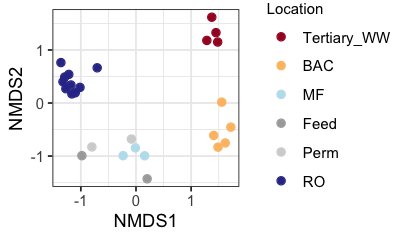

In [295]:
# Plot 
options(repr.plot.width = 3.4, repr.plot.height = 2)

location_colors=c('#A50026','#FDBE70','#BCE1EE',"dark gray","light gray",'#313695')

plot_ordination(ps_awtp, ps_dpwf_rare.ord, color="location_gen") + 
    geom_point(size=2, pch=21)+
    scale_color_manual(values=location_colors)+ #colorRampPalette(brewer.pal(11, "RdYlBu"))(8)
    #geom_text(aes(label=SampleID),hjust=1, vjust=1)+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))+
    theme_bw()+
        guides(color = guide_legend(title = "Location"))+
    theme(axis.text.x = element_text(size=9),
      axis.text.y = element_text(size=9),
      legend.text=element_text(size=9), 
      legend.title=element_text(size=9))
# ggsave('~/data/awtp2/amplicon_16S/figures/dpwf_rare_NMDS.svg', device='svg', width = 3.4, height = 2)

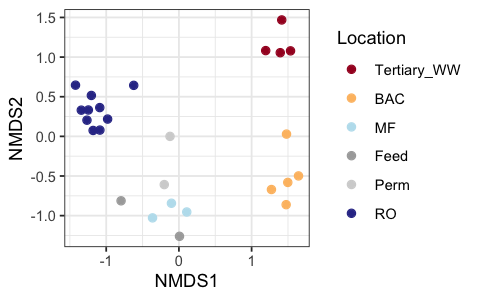

In [64]:
# Plot 
options(repr.plot.width = 4, repr.plot.height = 2.5)

location_colors=c('#A50026','#FDBE70','#BCE1EE',"dark gray","light gray",'#313695')

plot_ordination(ps_dpwf_perc, ps_dpwf_perc.ord, color="location_gen") + 
    geom_point(size=2, pch=21)+
    scale_color_manual(values=location_colors)+ #colorRampPalette(brewer.pal(11, "RdYlBu"))(8)
    #geom_text(aes(label=SampleID),hjust=1, vjust=1)+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))+
    theme_bw()+
    guides(color = guide_legend(title = "Location"))
#ggsave('~/data/awtp2/amplicon_16S/figures/dpwf_perc_NMDS.pdf', device='pdf', width = 4, height = 2.5)
# ggsave('~/data/awtp2/amplicon_16S/figures/dpwf_perc_NMDS.png', device='png', width = 4, height = 2.5)

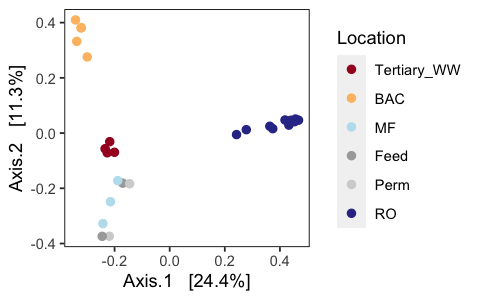

In [69]:
ps_dpwf_perc_all.ord <- ordinate(ps_dpwf_perc, "PCoA", "bray")

options(repr.plot.width = 4, repr.plot.height = 2.5)

plot_ordination(ps_dpwf_perc, ps_dpwf_perc_all.ord, color="location_gen") + 
    geom_point(size=2)+
    scale_color_manual(values = location_colors,
                       name="Location")+ #labels=c("WW_3ary", "BAC", "MF", "RO mem. retentate side", "RO mem. permeate side", "RO")
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA))
#ggsave('~/data/awtp2/amplicon_16S/figures/dpwf_PCoA.pdf', device='pdf', width = 4, height = 2.5)

## PERMANOVA with 3 different data normalizations

In [303]:
#Normalized by percent (changed the order of formula and result is similar)
sample_info = as((sample_data(ps_dpwf_bulk_perc)), "data.frame")
bulk_bray_perc = phyloseq::distance(ps_dpwf_bulk_perc, "bray")
bulk_adonis = adonis2(bulk_bray_perc ~ sample_day + location_gen, sample_info)
bulk_adonis

#rarefied
sample_info = as((sample_data(ps_dpwf_bulk)), "data.frame")
ps_dpwf_bulk_rare <- rarefy_even_depth(ps_dpwf_bulk)
bray_rare = phyloseq::distance(ps_dpwf_bulk_rare, "bray")
adonis_rare = adonis2(bray_rare ~ location_gen + sample_date, sample_info)
adonis_rare

##CLR-transformed Euclidean distance (Aitchison distance) 
##Suggested in Gloor et al 2017: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5695134/
ps_bulk_clr <- microbiome::transform(ps_dpwf_bulk, transform='clr')
sample_info = as(sample_data(ps_bulk_clr), "data.frame")
bulk_eucl = phyloseq::distance(ps_bulk_clr, "euclidean")
bulk_adonis_clr = adonis2(bulk_eucl ~ location_gen + sample_date, sample_info)
bulk_adonis_clr

,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
sample_day,1,0.3545853,0.04104199,1.514318,0.096
location_gen,3,4.3043506,0.49821334,6.127491,0.001
Residual,17,3.9806373,0.46074467,NA,NA
Total,21,8.6395731,1.00000000,NA,NA


You set `rngseed` to FALSE. Make sure you've set & recorded
 the random seed of your session for reproducibility.
See `?set.seed`


...

915OTUs were removed because they are no longer 
present in any sample after random subsampling


...



,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
location_gen,3,4.318443,0.49932231,6.100635,0.001
sample_date,1,0.318914,0.03687461,1.351583,0.153
Residual,17,4.011251,0.46380308,NA,NA
Total,21,8.648607,1.00000000,NA,NA


,Df,SumOfSqs,R2,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
location_gen,3,32874.667,0.49543909,5.957471,0.001
sample_date,1,2209.996,0.03330584,1.201471,0.218
Residual,17,31269.946,0.47125507,NA,NA
Total,21,66354.609,1.00000000,NA,NA


## Check for heterogeneity of beta-dispersions

In [305]:
beta <- betadisper(bulk_eucl, sample_info$location_gen)
permutest(beta, permutations = 10000)


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 10000

Response: Distances
          Df Sum Sq Mean Sq      F N.Perm    Pr(>F)    
Groups     3 3501.8 1167.26 28.674  10000 9.999e-05 ***
Residuals 18  732.7   40.71                            
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

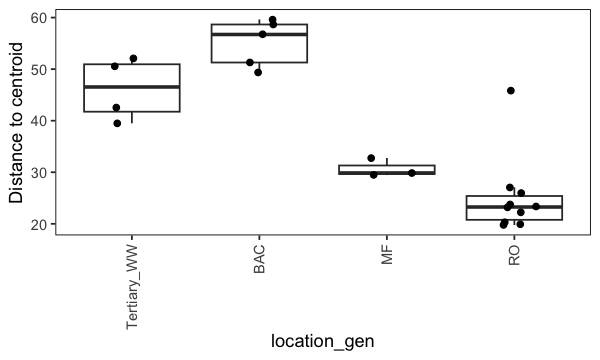

In [277]:
betadisper_distances <- as.data.frame(beta$distances)
colnames(betadisper_distances) <- c('distance_to_centroid')
betadisper_distances <- merge(betadisper_distances, sample_info, by = 0)

options(repr.plot.width = 5, repr.plot.height = 3) #for plotting size in jupyter
ggplot(betadisper_distances, aes(x=location_gen, y=distance_to_centroid))+
    geom_boxplot(outlier.shape = NA)+
    geom_jitter(position=position_jitter(0.2))+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA), axis.text.x = element_text(angle = 90, hjust = 1, vjust = .5))+
    ylab('Distance to centroid')
# ggsave("~/data/awtp2/amplicon_16S/figures/beta_dispersion.pdf", device="pdf", width=5, height=3)
# ggsave("~/data/awtp2/amplicon_16S/figures/beta_dispersion2.png", device="png", width=5, height=3)

# Shared ASVs across treatment processes

In [76]:
#function to identify core community within a location 
get_core_seqs <- function(ps_name, min_abund, min_samples, location){
    location_ids = as.character(get_variable(ps_name, "location_gen")) == location
    ps_sub <- prune_samples(location_ids, ps_name) #subsample by location
    
    #where number of samples=min_samples, for counts input min_reads-1 (because KOverA uses > not >=)
    core <- filter_taxa(ps_sub, filterfun(kOverA(min_samples, min_abund)), prune=TRUE) 
    return(row.names(tax_table(core))) #core sequences
}

In [94]:
sample_data(ps_dpwf_bulk_perc)$location_gen

[1] MF          BAC         BAC         Tertiary_WW Tertiary_WW Tertiary_WW
 [7] Tertiary_WW BAC         RO          RO          RO          RO         
[13] MF          MF          BAC         BAC         RO          RO         
[19] RO          RO          RO          RO         
Levels: Tertiary_WW BAC MF RO

In [134]:
# Set parameters
min_abund <- 0.05 #A percentage or reads -- depends on dataset (rel. or absolute abundances)
min_samples <- 2 #k
dataset <- ps_dpwf_bulk_perc

# Select core community of all different treatment steps
core.WW3 <- get_core_seqs(dataset, min_abund, min_samples, "Tertiary_WW") 
core.BAC <- get_core_seqs(dataset, min_abund, min_samples, "BAC")
core.MF <- get_core_seqs(dataset, min_abund, min_samples, "MF") 
core.RO <- get_core_seqs(dataset, min_abund, min_samples, "RO")

In [137]:
colorRampPalette(brewer.pal(11, "RdYlBu"))(4)

[1] "#A50026" "#FDBE70" "#BCE1EE" "#313695"

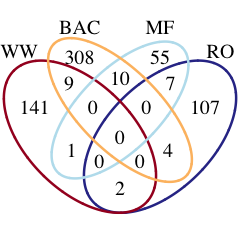

In [151]:
options(repr.plot.width = 2, repr.plot.height = 2)
#pdf("~/data/awtp2/amplicon_16S/figures/venn_diagram_0.05perc_2sampmin.pdf", width=2, height=2)
cores=list(
    "WW"=core.WW3,
    "RO"=core.RO,
    "BAC"=core.BAC,
    "MF"=core.MF    
    )
grid.draw(venn.diagram(cores, NULL, col=c('#A50026','#313695','#FDBE70','#BCE1EE'), 
                       fill=c("white", "white", "white", "white"))) #fill=c("white", "white", "white", "white")
#dev.off()

In [152]:
# # original colors
# options(repr.plot.width = 2, repr.plot.height = 2)
# #pdf("~/data/awtp2/amplicon_16S/figures/venn_diagram_0.05perc_2sampmin.pdf", width=2, height=2)
# cores=list(
#     "WW"=core.WW3,
#     "RO"=core.RO,
#     "BAC"=core.BAC,
#     "MF"=core.MF    
#     )
# grid.draw(venn.diagram(cores, NULL, col=c("gray", "#89C5DA", "#5F7FC7", "#DA5724" ), 
#                        fill=c("white", "#89C5DA", "#5F7FC7", "#DA5724")))
# #dev.off()

In [113]:
#plot cores
ps_core <- prune_taxa(unique(c(core.WW3,core.RO,core.BAC, core.MF)), dataset)
ps_core_filt1.1 <- filter_taxa(ps_core, filterfun(kOverA(1, 1)), TRUE)
ps_core_filt1.1

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 129 taxa and 22 samples ]
sample_data() Sample Data:       [ 22 samples by 27 sample variables ]
tax_table()   Taxonomy Table:    [ 129 taxa by 8 taxonomic ranks ]
refseq()      DNAStringSet:      [ 129 reference sequences ]

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Transformation introduced infinite values in discrete y-axis”
Warning message:
“Transformation introduced infinite values in discrete y-axis”


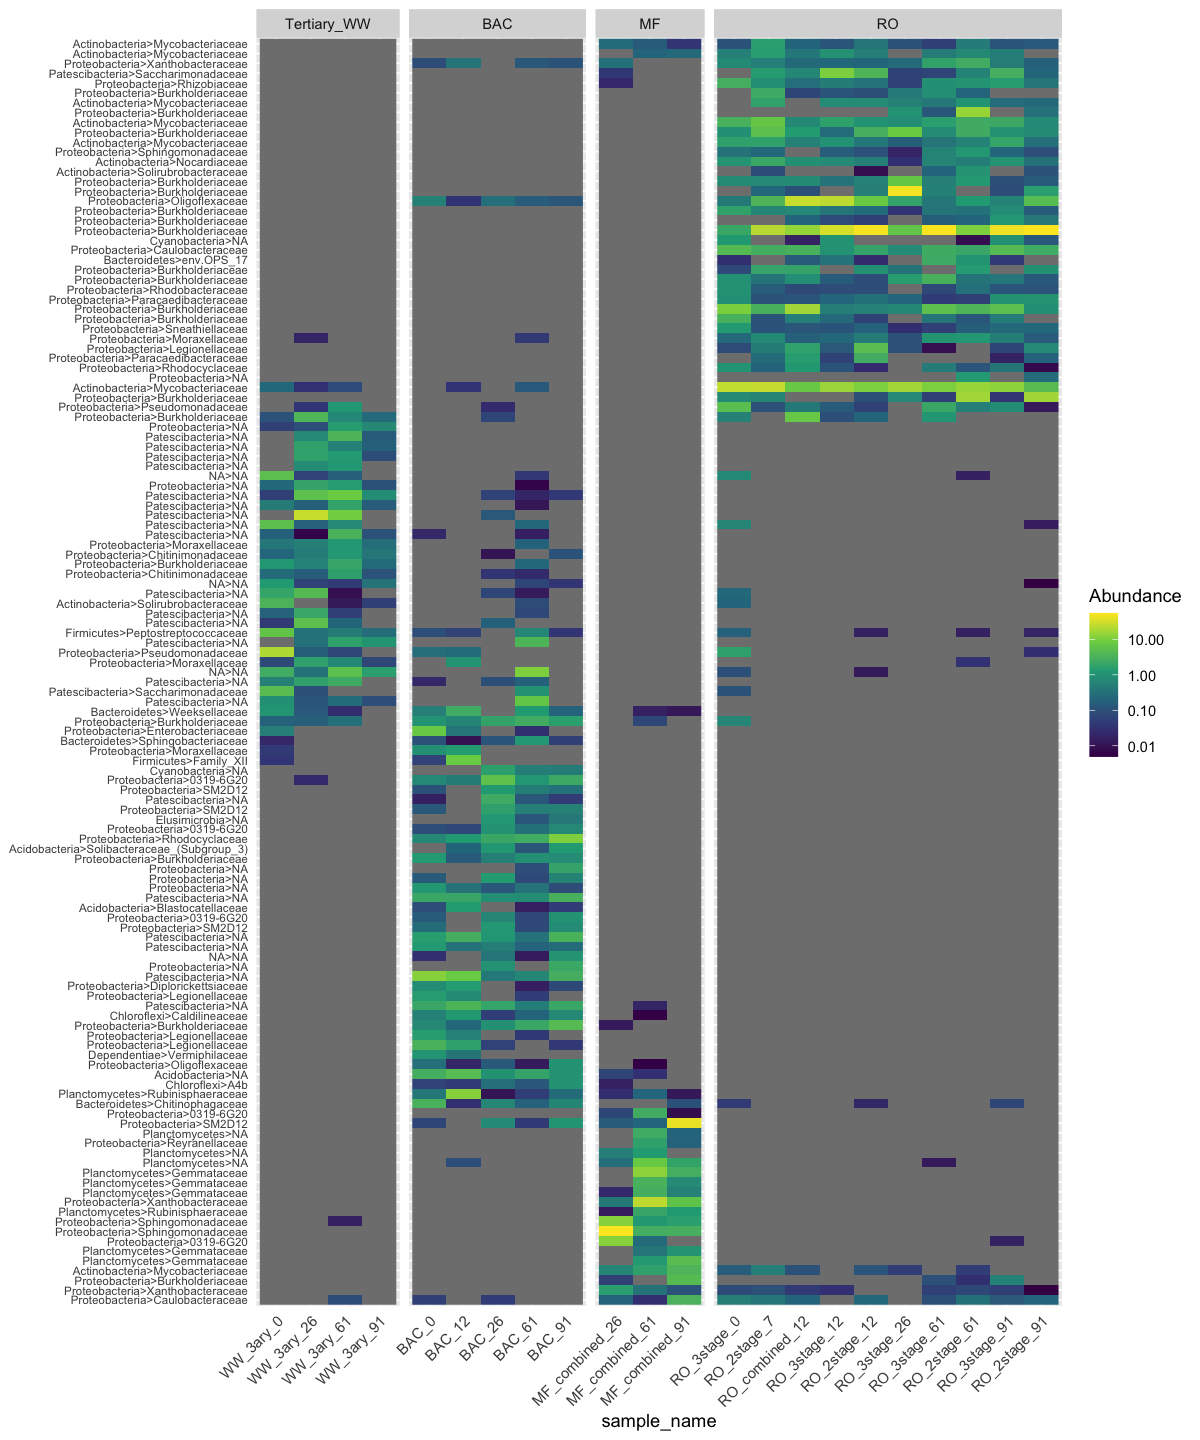

In [114]:
#plot heatmap
options(repr.plot.width = 10, repr.plot.height = 12)
plot_heatmap(ps_core_filt1.1, taxa.label = "phyfam", sample.label = "sample_name", sample.order = "sample_date", method="NMDS")+
            scale_fill_continuous(type='viridis', trans = log_trans(10))+
     theme(axis.text.y = element_text(size=7), 
           axis.title.y = element_blank(), 
           axis.ticks = element_blank(),
           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1, size=9))+
     facet_grid(.~location_gen, scale="free_x", space="free_x")
ggsave('~/data/awtp2/amplicon_16S/heatmap_cores_filt1.1.png', device='png', width=12, height=9)

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Transformation introduced infinite values in discrete y-axis”


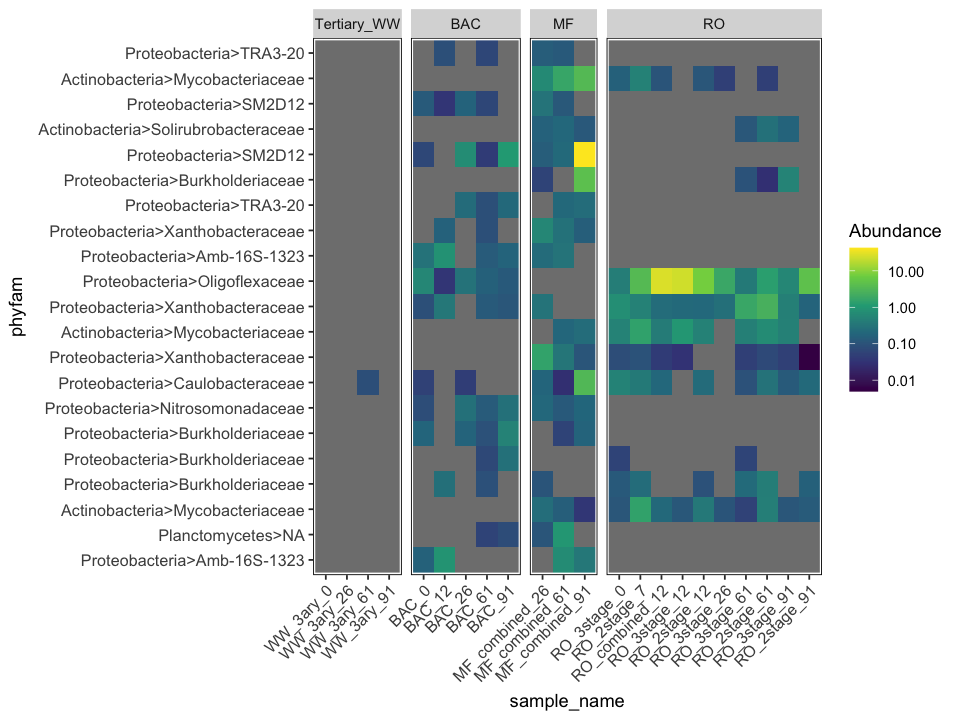

In [117]:
#plot all intersections
partitions <- get.venn.partitions(cores)
allover_seqs <- partitions[partitions$BAC==TRUE & partitions$WW3==TRUE,]$..values..
allover_seqs <- append(allover_seqs, partitions[partitions$BAC==TRUE & partitions$MF==TRUE,]$..values..)
allover_seqs <- append(allover_seqs, partitions[partitions$BAC==TRUE & partitions$RO==TRUE,]$..values..)
allover_seqs <- append(allover_seqs, partitions[partitions$RO==TRUE & partitions$MF==TRUE,]$..values..)
allover_seqs <- append(allover_seqs, partitions[partitions$RO==TRUE & partitions$WW3==TRUE,]$..values..)
allover_seqs <- append(allover_seqs, partitions[partitions$MF==TRUE & partitions$WW3==TRUE,]$..values..)

allover_seqs <- unname(c(unlist(allover_seqs))) #convert to unnamed vector
ps_allover <- prune_taxa(allover_seqs, dataset)

# options(repr.plot.width = 6, repr.plot.height = 4)
# plot_bar(ps_allover, x="sample_code_full_and_batch", fill="Family") + scale_fill_manual(values = colors) + 
#     theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
#           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
#     facet_grid(.~location_gen, scale="free_x", space="free_x")

options(repr.plot.width = 8, repr.plot.height = 6)
plot_heatmap(ps_allover, taxa.label = "phyfam", sample.label = "sample_name", sample.order = "sample_date", method=NULL)+
            scale_fill_continuous(type='viridis', trans = log_trans(10))+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
          axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    facet_grid(.~location_gen, scale="free_x", space="free_x")

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Warning message:
“Transformation introduced infinite values in discrete y-axis”


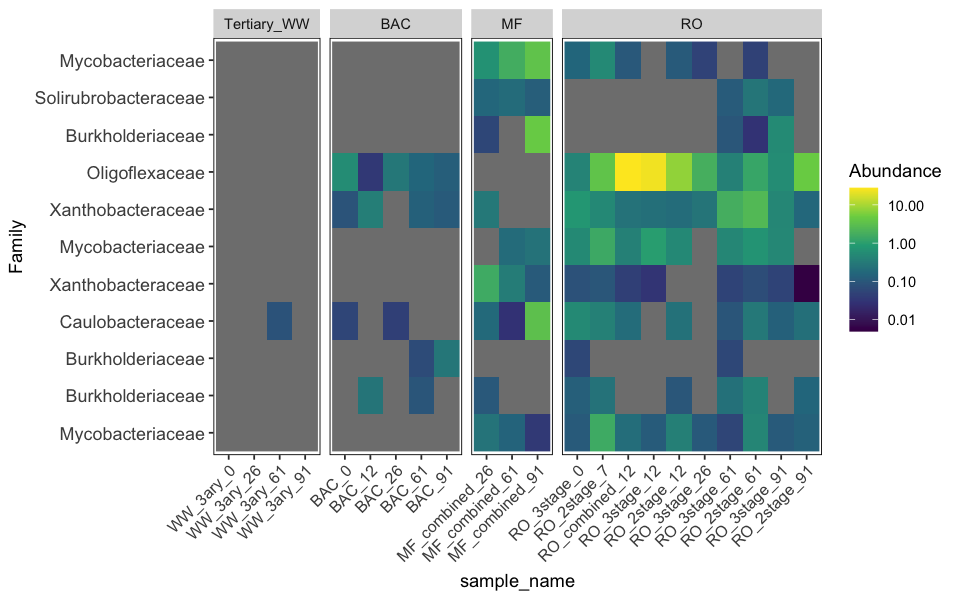

In [123]:
#plot RO shared core taxa
partitions <- get.venn.partitions(cores)
RO_seqs <- partitions[partitions$RO==TRUE & partitions$WW3==TRUE,]$..values..
RO_seqs <- append(RO_seqs, partitions[partitions$RO==TRUE & partitions$BAC==TRUE,]$..values..)
RO_seqs <- append(RO_seqs, partitions[partitions$RO==TRUE & partitions$MF==TRUE,]$..values..)

RO_seqs <- unname(c(unlist(RO_seqs))) #convert to unnamed vector
ps_RO_cross <- prune_taxa(RO_seqs, dataset)

# options(repr.plot.width = 6, repr.plot.height = 4)
# plot_bar(ps_RO_cross, x="sample_code_full_and_batch", fill="Family") + scale_fill_manual(values = colors) + 
#     theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
#           axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
#     facet_grid(.~location_gen, scale="free_x", space="free_x")

options(repr.plot.width = 8, repr.plot.height = 5)
plot_heatmap(ps_RO_cross, taxa.label = "Family", sample.label = "sample_name", sample.order = "sample_date", method=NULL)+
            scale_fill_continuous(type='viridis', trans = log_trans(10))+
    theme(panel.background=element_blank(), panel.border=element_rect(color = "black", fill = NA),
          axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1))+
    facet_grid(.~location_gen, scale="free_x", space="free_x")

In [153]:
# #what are these seqs and how abundant are they? Get otu table, tax table, merge, rename

# shared_otus <- as.data.frame(otu_table(ps_RO_cross)) #get otu table
# shared_otus <- as.data.frame(t(shared_otus)) #otus as rows
# shared_taxa <- as.data.frame(tax_table(ps_RO_cross) [, c("Family","Genus")]) #get tax table
# shared_seq_info <- merge(shared_otus, shared_taxa, by=0) #merge otus and tax tables

# shared_seq_info$taxonomy <- paste(shared_seq_info$Family, shared_seq_info$Genus, sep="_") #convert tax to family_genus
# row.names(shared_seq_info) <- shared_seq_info$taxonomy #make tax as rownames
# shared_seq_info <- subset(shared_seq_info, select=c(-Row.names, -Family, -Genus, -taxonomy)) #drop extra columns

# shared_seq_info <- t((shared_seq_info)) #transpose so taxa are columns, samples are rows
# shared_seq_info <- as.data.frame(shared_seq_info)
# names <- subset(sample_data(ps_RO_cross), select=c(Name, filtered_readcounts)) #get sample names for rows
# shared_seq_info <- merge(names, shared_seq_info, by=0)
# row.names(shared_seq_info) <- shared_seq_info$Name
# shared_seq_info <- subset(shared_seq_info, select=c(-Name, -Row.names))
# shared_seq_info <- shared_seq_info[order(row.names(shared_seq_info)),] #sort by sample name

# shared_seq_info


# RO Biofilm samples
Remove A69 because it had 0.07 ng/ul, probably not good data